In [2]:
 #Import All Libraries Here
import pandas as pd
from sklearn.metrics import accuracy_score ,  roc_curve, auc , classification_report

import numpy as np
from sklearn.metrics import classification_report, accuracy_score

from sklearn.metrics import mean_squared_error
import optuna
from torch.utils.data import WeightedRandomSampler
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import RandomOverSampler
import time
from collections import Counter
# PyTorch Import

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


WINDOW_SIZE = 50

# 1 - One Hot Encoding with Pytorch in build Emnedding 
# 2 - 3-mer coding with number encoding
ENCODING_METHOD = 2

# 1- Random Over Sampling
# 2 - Weighted Over Sampler 
SAMPLING_METHOD =1 

# 1 - LSTM with Cross Entropy 
MODEL = 1


FRAMEWORK = "PYTORCH"

# Startegy to Crop Sequene
# MID - Modification is present at Mid of cropped Sequence 
# END - Modification is present at End of cropepd Sequence 
CROP_STRATEGY = 'END'

# Y Category Encoding Method
# LABEL or ONE_HOT  
TARGET_ENCODING = 'LABEL'



In [3]:
# Record Constants
INPUT_TRAIN_IN = "../../data/train_in.csv"
INPUT_TRAIN_OUT = "../../data/train_out.csv"  
INPUT_TEST_IN = "../../data/test_in.csv"
INPUT_TEST_OUT = "../../data/test_out.csv"
INPUT_VALIDATION_IN = "../../data/valid_in_nucleo.csv"
INPUT_VALIDATION_OUT  = "../../data/valid_out.csv"

TARGET_MODEL_PATH = '../../webapp/model_files'




In [4]:
#Read X Varaibles and Y Varaibles

x_train_raw =  pd.read_csv(INPUT_TRAIN_IN, header=None , skiprows=1 )
y_train_raw =  pd.read_csv(INPUT_TRAIN_OUT, header=None , skiprows=1 )

x_test_raw =  pd.read_csv(INPUT_TEST_IN, header=None , skiprows=1 )
y_test_raw =  pd.read_csv(INPUT_TEST_OUT, header=None , skiprows=1)

x_valid_raw =  pd.read_csv(INPUT_VALIDATION_IN, header=None , skiprows=1 )
y_valid_raw =  pd.read_csv(INPUT_VALIDATION_OUT, header=None , skiprows=1 )

x_data = pd.concat([x_train_raw, x_test_raw, x_valid_raw], axis=0, ignore_index=True)
y_data = pd.concat([y_train_raw, y_test_raw, y_valid_raw], axis=0, ignore_index=True)

print(f"Train Shape of X : {x_train_raw.shape} and Tranin Shape of Y : {x_train_raw.shape}")
print(f"Test Shape of X : {x_test_raw.shape} and Test Shape of Y : {y_test_raw.shape}")
print(f"Validation Shape of X : {x_valid_raw.shape} and Validation Shape of Y : {y_valid_raw.shape}")


Train Shape of X : (304661, 1001) and Tranin Shape of Y : (304661, 1001)
Test Shape of X : (1200, 1001) and Test Shape of Y : (1200, 12)
Validation Shape of X : (3599, 1001) and Validation Shape of Y : (3599, 12)


### Calculate Sequence Positions to extracted from Original Sequence 

In [5]:
middle_index = (x_train_raw.shape[1] // 2) + 1 # This is location for Modified Sequence . Use this as Y Target

if CROP_STRATEGY == 'MID':
    STRAT_INEDX =middle_index - WINDOW_SIZE -1 
    END_INDEX =middle_index + WINDOW_SIZE 

if CROP_STRATEGY == 'END':
    STRAT_INEDX =middle_index - (WINDOW_SIZE*2) -1 
    END_INDEX =middle_index

x_data_cropped =  x_data.iloc[:,STRAT_INEDX :END_INDEX]  
concatenated_column= x_data_cropped.apply(lambda row: ''.join(map(str, row)), axis=1)
x_data_cropped = x_data_cropped.assign(Sequence=concatenated_column)

In [6]:
x_data_cropped

,400,401,402,403,404,405,406,407,408,409,...,492,493,494,495,496,497,498,499,500,Sequence
0,G,G,G,C,G,C,C,T,C,G,...,T,C,A,T,C,A,T,C,A,GGGCGCCTCGGCTCTTGTCCACGCCCTGGACCGCGGGGACCGCGAG...
1,A,A,C,A,G,T,A,A,A,C,...,G,T,C,A,A,T,T,C,A,AACAGTAAACCAAATGCATTGTAACATCTTATTTAATTCTAACATG...
2,A,A,A,G,A,A,C,A,T,G,...,T,C,T,C,T,G,A,C,A,AAAGAACATGCTTCTTCCTTCTTAGTATATAGATCAGGATCCACTT...
3,G,G,G,T,G,G,T,G,C,C,...,A,T,A,T,T,A,A,G,A,GGGTGGTGCCTGGACAGAGTGAGTGTCTAATGATTGCTAAAGTAAT...
4,T,C,A,T,T,G,A,A,G,T,...,G,G,T,T,T,G,A,A,A,TCATTGAAGTTTTTTTGATCACAGGAATAACATGTTTAGATAGTAA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309455,T,T,T,T,C,T,A,G,T,G,...,G,T,A,G,A,C,T,T,A,TTTTCTAGTGCCCCCCTCTTAAGTGTCCTGACTGCAGATTCTAGGC...
309456,A,T,T,C,T,G,A,T,C,A,...,A,A,A,A,G,G,T,T,A,ATTCTGATCAGTAACTTTGTGTATGATGCTGAATTACAAACCGTTT...
309457,C,A,G,A,A,G,A,A,A,T,...,T,A,T,C,T,A,C,T,A,CAGAAGAAATGATATATCCTGTCCAGACACTGAATGCACTTCTTCC...
309458,A,A,G,G,T,C,T,C,C,T,...,A,T,G,G,A,T,G,A,A,AAGGTCTCCTGCAAGGCTTCTGGATACACCTTCACCAGTTATGATA...


In [38]:
x_train_raw = None
y_train_raw = None
x_test_raw = None
y_test_raw = None
x_valid_raw = None
y_valid_raw = None

### Apply One Hot Encoding

In [39]:
number_of_unique_kmers = set()
def encode_seq(kmer_token):

    # A 1 0 0 0
    # C 0 1 0 0
    # T/U 0 0 0 1
    # G 0 0 1 0
    # N 0 0 0 0

    encoding_dict = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'U': [0, 0, 0, 1],
        'N': [0, 0, 0, 0],
    }

    encoded_sequence = []
    number_of_unique_kmers.add(kmer_token)
    for  base in kmer_token:
        encoded_sequence.append(encoding_dict[base])
    return np.array(encoded_sequence).flatten()

def applyOneHotEncoding(tokenized_sequences):
    encoded_sequences = []
    for seq in tokenized_sequences:
        encoded_sequences.append(encode_seq(seq)) 
 
    return np.array(encoded_sequences).flatten()

def encode_with_one_hot_encoding(x_train_raw):
    truncated_df =  x_train_raw.iloc[:,STRAT_INEDX :END_INDEX] # Window Starts from V501 with 50 window size
    concatenated_column= truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    df_result = truncated_df.assign(Sequence=concatenated_column)
    tokenized_sequences =  df_result['Sequence'].apply(applyOneHotEncoding).tolist()
    
    return tokenized_sequences


In [41]:
## Filter Dataset to Keep only Target Binary Class 

RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
RMEncoding = [12,1,2,3,4,5,6,7,8,9,10,11,0]

ARMs = ['hm6A', 'hm1A' , 'hAm' , 'Atol' , 'hm6Am']
ARMEncoding = [0,1,2,3,4]

def convert_y_to_original_labels(row):
    label = ""
    for index , n in enumerate(row.tolist()) :
        if n == 1 :
            label = RMs[index]
    if label == '':
        return 'NonMoD'
    return label

def get_original_y_lables( y_data ):
    # Convert One Hot Encoded Y to to Original Labels 
    y_original_labels = y_data.apply(convert_y_to_original_labels,axis=1)
    return y_original_labels  



def encode_target(y_data):
    # Write Customer Lable Encoder . This is required since we have train and test alreday splitted. Always creating a new instanc of label encoder will change encoding.

    y_encoded = []
    for y in y_data:
        index = ARMs.index(y)
        encoding =  ARMEncoding[index]
        y_encoded.append(encoding)
    return y_encoded

def prepare_data_for_binary_classification(x_data , y_data , prediction_class):
    # Convert One Hot Encoded Y to to Original Labels 
    y_original_labels = y_data.apply(convert_y_to_original_labels,axis=1)
    x_data['Label'] = y_original_labels
    target_class = prediction_class   
    selected_rna_data = x_data[x_data['Label'].isin(target_class)] 

    y_filtered = selected_rna_data['Label']
    x_filtered = selected_rna_data.drop('Label', axis=1)

    return x_filtered , y_filtered 

In [42]:
class_A_list = ['hm6A', 'hm1A' , 'hAm' , 'Atol' , 'hm6Am']

x_data_filtered , y_data_filtered = prepare_data_for_binary_classification(x_data , y_data , class_A_list)
x_encoded = encode_with_one_hot_encoding(x_data_filtered) 
y_encoded = encode_target(y_data_filtered)

# Train set
X_train, X_test, y_train, y_test = train_test_split(x_encoded, y_encoded, test_size=0.3, random_state=42)

# x_train_filtered , y_train_filtered  =  prepare_data_for_binary_classification(x_train_raw , y_train_raw , class_A_list)
# x_test_filtered  ,  y_test_filtered =  prepare_data_for_binary_classification(x_test_raw , y_test_raw , class_A_list)
# x_valid_filtered ,  y_valid_filtered =  prepare_data_for_binary_classification(x_valid_raw , y_valid_raw , class_A_list)


# X_train = encode_with_one_hot_encoding(x_train_filtered) 
# X_test = encode_with_one_hot_encoding(x_test_filtered)
# X_valid = encode_with_one_hot_encoding(x_valid_filtered) 

# # Filter out Class A Type Nucloeside 

# y_train = encode_target(y_train_filtered)
# y_test = encode_target(y_test_filtered)
# y_valid = encode_target(y_valid_filtered)

In [43]:
print("Train Y Count : " ,Counter(y_train))
print("Test Y Count : " ,Counter(y_test))


Train Y Count :  Counter({0: 45515, 3: 36874, 1: 11487, 4: 1757, 2: 1089})
Test Y Count :  Counter({0: 19663, 3: 15744, 1: 4854, 4: 690, 2: 502})


In [44]:
# Reduced Memory Footprint
x_data = None
y_date = None
x_data_filtered=None
y_data_filtered =None
x_encoded = None
y_encoded = None


### Apply Word2Vec Model

In [45]:
# Model Documentation - 
# Encode RNA sequences using Word2Vec embeddings
def encode_sequence(sequence , word2vec_model):
    embeddings = []
    for kmer in sequence:
        embeddings.append(word2vec_model.wv[kmer])
    return np.mean(embeddings, axis=0)

def applyKmersAndEncoding(seq):
    k = 3
    tokenized_sequences = [''.join(seq[i:i+k]) for i in range(0, len(seq)-k+1)]
    return tokenized_sequences
    


def encode_x_with_word2Vec(x_train_raw):
    truncated_df =  x_train_raw.iloc[:,STRAT_INEDX :END_INDEX] # Window Starts from V501 with 50 window size
    truncated_df['Sequence'] = truncated_df.apply(lambda row: ''.join(map(str, row)), axis=1)
    tokenized_sequences =  truncated_df['Sequence'].apply(applyKmersAndEncoding).tolist()
    
    # The result, tokenized_sequences, is a list of lists, where each inner list
    #  contains the k-mers of the corresponding RNA sequence from the truncated_df list. 
    embedding_size = 100
    word2vec_model = gensim.models.Word2Vec(tokenized_sequences, vector_size=embedding_size, window=5, min_count=1, workers=4)

    result = []
    for seq in tokenized_sequences:
        embedding = encode_sequence(seq , word2vec_model)
        result.append(embedding)
    return result 


### Apply 3-mer with Numerical Encoding

In [7]:
kmer_dict = {}
encoding = 0
k = 3

for sequence in x_data_cropped['Sequence']:
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i+k]
        if kmer not in kmer_dict:
            kmer_dict[kmer] = encoding
            encoding += 1

def encode_with_k_mer_codon(sequence):
    encoded_sequence = [] 
    for i in range(len(sequence) - k + 1):
        encoded_sequence.append(kmer_dict[sequence[i:i+k]] )
        
    return np.array(encoded_sequence)

In [8]:
RMs = ['hAm','hm1A','hm6A','hm6Am','Atol']
RMEncoding = [0,1,2,3,4]

All_RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
All_RMEncoding = [12,1,2,3,4,5,6,7,8,9,10,11,0]


def convert_y_to_original_labels(row):
    label = ""
    for index , n in enumerate(row.tolist()) :
        if n == 1 :
            label = All_RMs[index]
    if label == '':
        return 'NonMoD'
    return label

def encode_target(y_data):
    # Write Customer Lable Encoder . This is required since we have train and test alreday splitted. Always creating a new instanc of label encoder will change encoding.
    y_encoded = []
    for y in y_data:
        index = RMs.index(y)
        encoding =  RMEncoding[index]
        y_encoded.append(encoding)
    return y_encoded

def prepare_data_for_binary_classification(x_data , y_data , prediction_class):
    # Convert One Hot Encoded Y to to Original Labels 
    y_original_labels = y_data.apply(convert_y_to_original_labels,axis=1)
    x_data['Label'] = y_original_labels
    target_class = prediction_class   
    selected_rna_data = x_data[x_data['Label'].isin(target_class)] 

    y_filtered = selected_rna_data['Label']
    x_filtered = selected_rna_data.drop('Label', axis=1)

    return x_filtered , y_filtered 


modification_list= ['hAm','hm1A','hm6A','hm6Am','Atol']

x_data_filtered , y_data_filtered = prepare_data_for_binary_classification(x_data_cropped , y_data , modification_list)




In [13]:
y_data_filtered.value_counts()


hm6A     65178
Atol     52618
hm1A     16341
hm6Am     2447
hAm       1591
Name: Label, dtype: int64

In [19]:
X_encoded  =  x_data_filtered['Sequence'].apply(encode_with_k_mer_codon)
X_encoded = torch.tensor(X_encoded , dtype =  torch.long)

y_encoded = encode_target(y_data_filtered)
y_encoded =  torch.tensor(y_encoded , dtype=torch.long) 

print("Generate Train and Split..")
# Train set
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)

# Test and Validation set
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


Generate Train and Split..


In [20]:
print(X_train.shape)
print(y_train.shape)

torch.Size([96722, 99])
torch.Size([96722])


In [21]:
sm = RandomOverSampler(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)
y_resampled = torch.tensor(y_resampled , dtype=torch.long)


In [26]:
X_resampled[1]

array([32, 17, 24,  5, 20, 21,  1,  4,  5, 54, 45, 47, 41, 15, 19,  5, 11,
       50, 51, 49, 52, 52, 53, 10, 54, 45, 34, 35, 36, 55, 57, 27, 28, 27,
       28, 62, 59, 51, 49, 52, 52, 50, 38, 24, 16, 33, 34, 61,  4, 16, 43,
       44, 14, 10, 11, 12, 13, 14, 10, 20, 21,  0,  0, 22, 27, 35,  0, 22,
       62, 59, 51, 49, 52, 53, 10, 54, 45, 34, 35,  0, 22, 62, 49, 50, 45,
       46, 34, 35, 22, 23, 30, 43, 61,  4, 16, 40, 41, 10, 54],
      dtype=int64)

### Re-Sample Data Using RandomOverSampler

In [27]:

print("Count for Training Data")
counts = torch.bincount(y_resampled)
for i, count in enumerate(counts):
    print(f"Value: {i}, Count: {count}")

print("Count for Test Data")
counts = torch.bincount(y_test)
for i, count in enumerate(counts):
    print(f"Value: {i}, Count: {count}")

print("Count for Valid Data")    
counts = torch.bincount(y_valid)
for i, count in enumerate(counts):
    print(f"Value: {i}, Count: {count}")


Count for Training Data
Value: 0, Count: 45515
Value: 1, Count: 45515
Value: 2, Count: 45515
Value: 3, Count: 45515
Value: 4, Count: 45515
Count for Test Data
Value: 0, Count: 256
Value: 1, Count: 2427
Value: 2, Count: 9830
Value: 3, Count: 326
Value: 4, Count: 7888
Count for Valid Data
Value: 0, Count: 246
Value: 1, Count: 2427
Value: 2, Count: 9833
Value: 3, Count: 364
Value: 4, Count: 7856


In [37]:
hyperparameter = {}
hyperparameter['INPUT_DIMENSION'] = len(kmer_dict) # For One Hot Encoding Input Dimension would be 4 as there only 4 unique nucleocide 
hyperparameter['HIDDEN_DIMENSION'] = 32
hyperparameter['NO_OF_LAYERS'] = 1
hyperparameter['BATCH_SIZE'] = 32
hyperparameter['OUTPUT_DIMENSION'] = 5
hyperparameter['EMBEDDING_DIMENSION'] = 128 # if you are using Word2Vec Encoding then this should be same as Word2Vec Embedding Dim 
hyperparameter['DROP_OUT'] = 0.1


class RNADataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset = RNADataset(X_train, y_train)
test_dataset = RNADataset(X_test, y_test)
valid_dataset = RNADataset(X_valid, y_valid)


if SAMPLING_METHOD == 1:
  train_dataset = RNADataset(X_resampled, y_resampled)
  train_dataloader = DataLoader(train_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle = True)

if SAMPLING_METHOD == 2:
  train_dataloader = DataLoader(train_dataset, batch_size=hyperparameter['BATCH_SIZE'], sampler=sampler)

test_dataloader = DataLoader(test_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=hyperparameter['BATCH_SIZE'], shuffle=False)

In [29]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.unsqueeze(1)
        hidden = hidden.expand(-1, encoder_outputs.size(1), -1)
        alignment_scores = self.v(torch.tanh(self.W(hidden + encoder_outputs)))
        attention_weights = F.softmax(alignment_scores, dim=1)
        context_vector = torch.sum(attention_weights * encoder_outputs, dim=1)
        return context_vector, attention_weights

class RNATransferLearning(nn.Module):
    def __init__(self, input_dim,embedding_dim, hidden_dim, num_layers, output_dim, dropout=0.5):
        super(RNATransferLearning, self).__init__()

        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.attention = BahdanauAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim) 
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.long()
        x_embeded = self.embedding(x)

        lstm_out, (h, c) = self.lstm(x_embeded)
        
        hidden = h.squeeze(0)

        #apply attention using the last hidden state and the encoder outputs
        context_vector, attention_weights = self.attention(hidden, lstm_out)
        
        #dropout
        output = self.dropout(context_vector)

        #final output
        out = self.fc(output)
        
        return out


In [30]:
def validate_model(model, test_dataloader , device ,loss_function):
    model.eval()
    running_loss = 0.0
    class_correct = [0] * hyperparameter['OUTPUT_DIMENSION'] 
    class_total = [0] * hyperparameter['OUTPUT_DIMENSION'] 
    total = 0
    correct = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.long().to(device)

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            true_labels.extend(labels.cpu().numpy())  # Capture True Lables for Summary Report
            predicted_labels.extend(predicted.cpu().numpy()) # Capture Predicted Labels Lables for Summary Report

    validation_loss = running_loss / len(test_dataloader)
    validation_accuracy = correct / total
    
    return validation_loss , validation_accuracy , true_labels , predicted_labels


def train_model(model, train_dataloader, test_dataloader, device, epochs, optimizer, loss_function):
    best_val_loss = float('inf')
    no_improvement_count = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        start_time = time.time()
        
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.long().to(device)

            optimizer.zero_grad()
            outputs = model(inputs) 
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_dataloader)
        val_loss,  validation_accuracy , true_labels , predicted_labels = validate_model(model, test_dataloader, device, loss_function) 
        end_time = time.time()
        elapsed_time = end_time - start_time    
        
        print(f"Epoch {epoch + 1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Test Accuracy: {validation_accuracy:.4f} , Time Taken : {elapsed_time}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1
            if no_improvement_count == 10:
                print("No improvement in validation loss for 5 epochs. Training stopped.")
                break



In [40]:
model = RNATransferLearning(input_dim=hyperparameter['INPUT_DIMENSION'],
                            embedding_dim=hyperparameter['EMBEDDING_DIMENSION'], 
                            hidden_dim=hyperparameter['HIDDEN_DIMENSION'] , 
                            num_layers = hyperparameter['NO_OF_LAYERS'],
                            output_dim=hyperparameter['OUTPUT_DIMENSION'],
                            dropout=hyperparameter['DROP_OUT'] )


loss_function = nn.CrossEntropyLoss()  ## MSELoss of Regression problem  # BCELoss for binary classification
optimizer = optim.Adam(model.parameters() ,  lr=0.01)

# Number of Parameters for Model
total_parameters = []
for p in model.parameters():
    total_parameters.append(p.numel())

print(f"Total Number of Parameters for Model Training : { sum(total_parameters)} " )

# Train the model
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Model Parameters  : " , hyperparameter)

# Train Model with configured Parameter
train_model(model, train_dataloader ,test_dataloader, device ,num_epochs,optimizer,loss_function)

Total Number of Parameters for Model Training : 30182 
Model Parameters  :  {'INPUT_DIMENSION': 64, 'HIDDEN_DIMENSION': 32, 'NO_OF_LAYERS': 1, 'BATCH_SIZE': 32, 'OUTPUT_DIMENSION': 5, 'EMBEDDING_DIMENSION': 128, 'DROP_OUT': 0.1}
Epoch 1, Train Loss: 1.2014, Val Loss: 1.1680, Test Accuracy: 0.5967 , Time Taken : 75.24840879440308
Epoch 2, Train Loss: 1.1969, Val Loss: 1.2723, Test Accuracy: 0.5422 , Time Taken : 110.71348166465759
Epoch 3, Train Loss: 1.1939, Val Loss: 1.1677, Test Accuracy: 0.5713 , Time Taken : 178.9677712917328
Epoch 4, Train Loss: 1.1967, Val Loss: 1.2146, Test Accuracy: 0.5493 , Time Taken : 204.41226649284363
Epoch 5, Train Loss: 1.1958, Val Loss: 1.2000, Test Accuracy: 0.5386 , Time Taken : 205.66281175613403
Epoch 6, Train Loss: 1.1922, Val Loss: 1.1891, Test Accuracy: 0.5342 , Time Taken : 205.89088320732117
Epoch 7, Train Loss: 1.1913, Val Loss: 1.1976, Test Accuracy: 0.5391 , Time Taken : 208.66443800926208
Epoch 8, Train Loss: 1.1900, Val Loss: 1.2276, Test 

In [35]:
# Evaluate the model on the test dataset
_, final_accuracy, true_labels, predicted_labels = validate_model(model, valid_dataloader,device,loss_function)

# Print the final accuracy
print(f"Final Accuracy: {final_accuracy:.4f}")

# Print the classification summary
print("\n Classification Summary:")
print(classification_report(true_labels, predicted_labels))

Final Accuracy: 0.5223

 Classification Summary:
              precision    recall  f1-score   support

           0       0.02      0.29      0.04       246
           1       0.15      0.02      0.03      2427
           2       0.67      0.97      0.79      9833
           3       0.16      0.89      0.27       364
           4       0.72      0.11      0.19      7856

    accuracy                           0.52     20726
   macro avg       0.34      0.46      0.26     20726
weighted avg       0.61      0.52      0.46     20726



### Train using XGBoost 

Test Accuracy: 0.57
Accuracy of XGBoost  model: 0.57


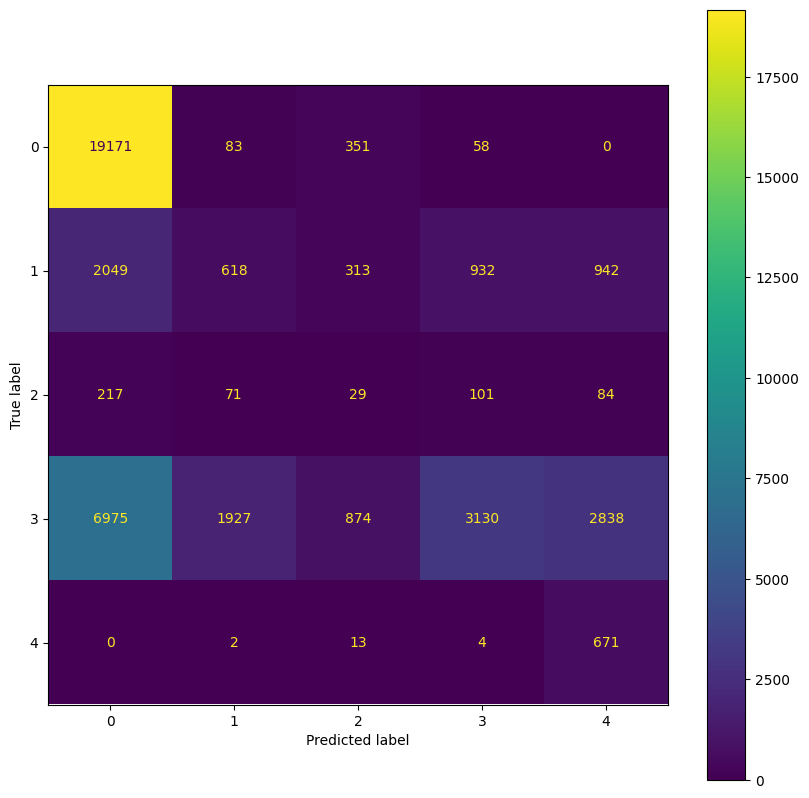

In [47]:
params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'max_depth': 4,
    'n_jobs': -1,
    'enable_categorical': True
}

dtrain = xgb.DMatrix(X_resampled, label=y_resampled)
num_rounds = 100 
model = xgb.train(params, dtrain, num_rounds)

dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest) 
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot confusion matrix 
cm = confusion_matrix(y_test, y_pred, labels=np.array(ARMEncoding))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=np.array(ARMEncoding))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))


### Rnadom Forest Model

Test Accuracy: 0.58
Accuracy of RandomForest model: 0.58


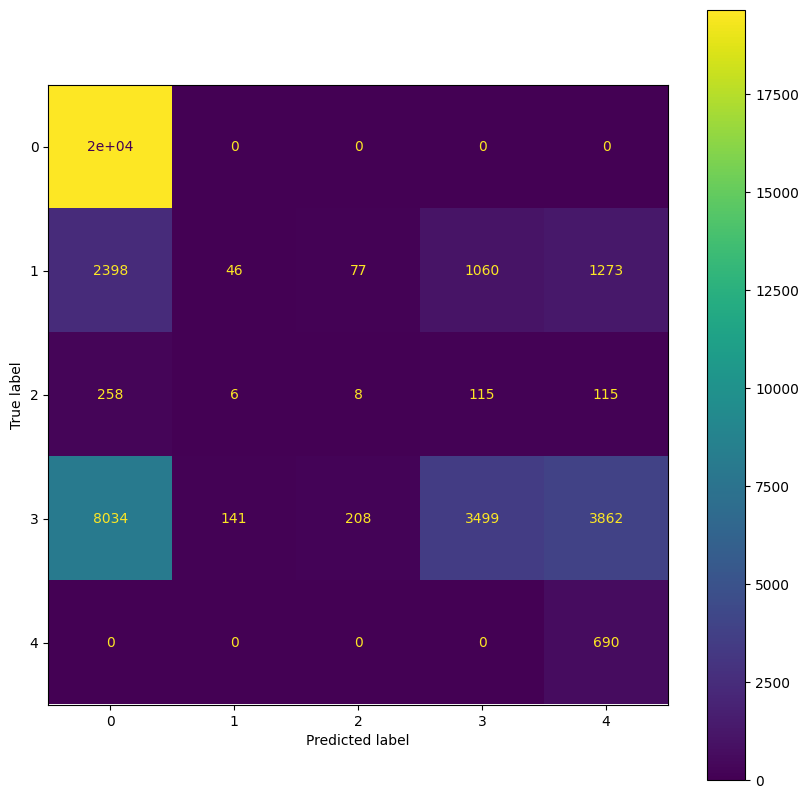

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Define and fit the model
rfc = RandomForestClassifier(max_depth=4, n_jobs=-1)
rfc.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = rfc.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot confusion matrix 
cm = confusion_matrix(y_test, y_pred, labels=np.array(ARMEncoding))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(ARMEncoding))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

print("Accuracy of RandomForest model: {:.2f}".format(accuracy))


### CatBoost Model

Test Accuracy: 0.58
Accuracy of CatBoost model: 0.58


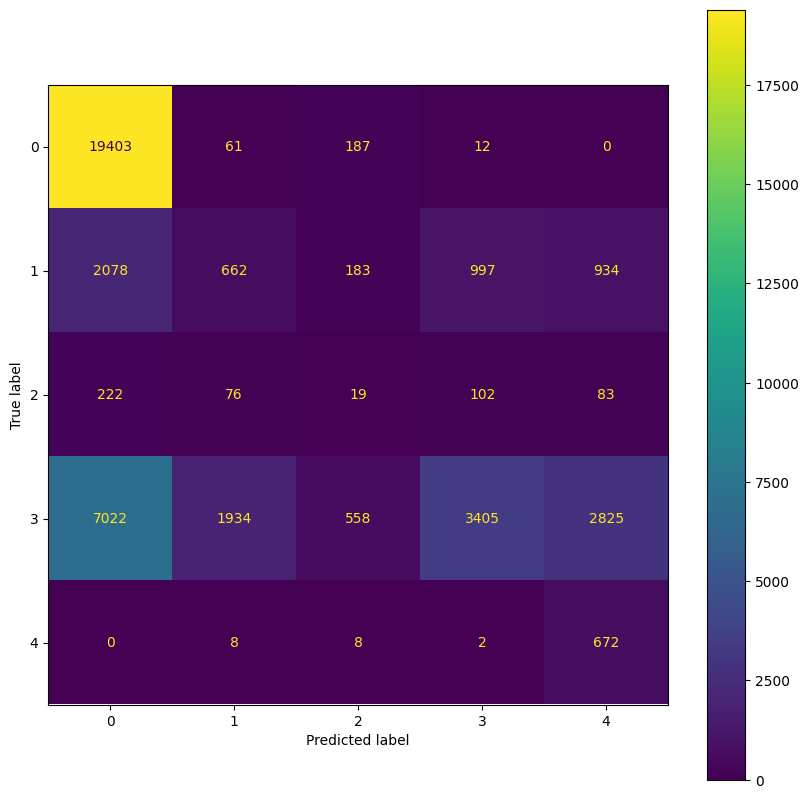

In [52]:
from catboost import CatBoostClassifier

# Define and fit the model
cbc = CatBoostClassifier(depth=4, loss_function='MultiClass', verbose=0)
cbc.fit(X_resampled, y_resampled)

# Predict on the test set
y_pred = cbc.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot confusion matrix 
cm = confusion_matrix(y_test, y_pred, labels=np.array(ARMEncoding))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(ARMEncoding))
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

print("Accuracy of CatBoost model: {:.2f}".format(accuracy))


# Optuna Hyperparmeter - Random Forest Search

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 2, 32),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
    }
    
    rfc = RandomForestClassifier(**params, n_jobs=-1)
    rfc.fit(X_resampled, y_resampled)

    y_pred = rfc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


### XgBoost with Hyper Paramter Tuning - RandomizedSearchCV

In [30]:
# if MODEL == 2:
#     # Create the XGBoost classifier
#     xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=13, random_state=42)

#     # Define the hyperparameter search space
#     param_dist = {
#         'learning_rate': [0.1, 0.01, 0.001],
#         'max_depth': [3, 5, 7, 10],
#         'min_child_weight':   [1, 3, 5],
#         'subsample': [0.5, 0.75, 1],
#         'colsample_bytree': [0.5, 0.75, 1],
#         'n_estimators': [100, 250, 500]
#     }

#     # Create the RandomizedSearchCV object
#     random_search = RandomizedSearchCV(xgb_clf, param_dist, cv=3, n_iter=20, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)

#     # Perform the randomized search
#     random_search.fit(X_train, y_train)

#     # Get the best hyperparameters
#     best_params = random_search.best_params_
#     print("Best hyperparameters:\n", best_params)

#     # Train the classifier with the best hyperparameters
#     best_xgb_clf = xgb.XGBClassifier(**best_params, objective='multi:softmax', num_class=13, random_state=42)
#     best_xgb_clf.fit(X_train, y_train)

#     # Make predictions on the test set
#     y_pred = best_xgb_clf.predict(X_test)

#     # Evaluate the model
#     print("Accuracy:", accuracy_score(y_test, y_pred))
#     print("\nClassification report:\n", classification_report(y_test, y_pred))

### XgBoost with Hyper Paramter Tuning - GridSearchCV

In [31]:
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import accuracy_score, classification_report

# if MODEL == 3:
#     # Create the XGBoost classifier
#     xgb_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=13, random_state=42 )

#     # Define the hyperparameter search space
#     param_grid = {
#         'learning_rate': [0.1, 0.01, 0.001],
#         'max_depth': [3, 5, 7, 10],
#         'min_child_weight': [1, 3, 5],
#         'subsample': [0.5, 0.75, 1],
#         'colsample_bytree': [0.5, 0.75, 1],
#         'n_estimators': [100, 250, 500]
#     }

#     # Create the GridSearchCV object
#     grid_search = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

#     # Perform the grid search
#     grid_search.fit(X_train, y_train)

#     # Get the best hyperparameters
#     best_params = grid_search.best_params_
#     print("Best hyperparameters:\n", best_params)

#     # Train the classifier with the best hyperparameters
#     best_xgb_clf = xgb.XGBClassifier(**best_params, objective='multi:softmax', num_class=13, random_state=42)
#     best_xgb_clf.fit(X_train, y_train)

#     # Make predictions on the test set
#     y_pred = best_xgb_clf.predict(X_test)

#     # Evaluate the model
#     print("Accuracy:", accuracy_score(y_test, y_pred))
#     print("\nClassification report:\n", classification_report(y_test, y_pred))

### Optimization with Optuna With XgBoost

In [32]:
# def objective(trial):
#     dtrain = xgb.DMatrix(X_train, label=y_train)
#     dvalid = xgb.DMatrix(X_test, label=y_test)

#     param = {
#         "verbosity": 0,
#         "objective": "multi:softmax",
#         "num_class": 5 ,
#         # defines booster, gblinear for linear functions.
#         "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
#         # L2 regularization weight.
#         "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
#         # L1 regularization weight.
#         "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
#         # sampling ratio for training data.
#         "subsample": trial.suggest_float("subsample", 0.2, 1.0),
#         # sampling according to each tree.
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
#     }

#     if param["booster"] in ["gbtree", "dart"]:
#         # maximum depth of the tree, signifies complexity of the tree.
#         param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
#         # minimum child weight, larger the term more conservative the tree.
#         param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
#         param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
#         # defines how selective algorithm is.
#         param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
#         param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

#     if param["booster"] == "dart":
#         param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
#         param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
#         param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
#         param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

#     num_rounds = 100 
#     bst = xgb.train(param, dtrain , num_rounds )
#     preds = bst.predict(dvalid)
#     pred_labels = np.rint(preds)
#     accuracy = sklearn.metrics.accuracy_score(y_test, pred_labels)
#     return accuracy


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100, timeout=6000)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial

# print("  Value: {}".format(trial.value))
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

# # Number of finished trials:  76
# # Best trial:
# #   Value: 0.6052047652900752
# #   Params: 
# #     booster: gblinear
# #     lambda: 3.0789981964094497e-06
# #     alpha: 2.468290506036041e-06
# #     subsample: 0.8524524714955344
# #     colsample_bytree: 0.498783948236617

In [33]:
import numpy as np
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb
import optuna

def objective(trial):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)

    param = {
        "verbosity": 0,
        "objective": "multi:softmax",
        "num_class": 5 ,
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        # "tree_method" : "gpu_hist",
        "eval_metric": "mlogloss"
        
    }

    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "test-mlogloss")
    bst = xgb.train(param, dtrain, num_boost_round=500, evals=[(dvalid, "test")], early_stopping_rounds=10, callbacks=[pruning_callback])
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    accuracy = sklearn.metrics.accuracy_score(y_test, pred_labels)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=6000)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Could Achieve upto 67 % - Train on GPU now for faster parameter evaluation.


[I 2023-06-04 00:24:00,153] A new study created in memory with name: no-name-5456a8b3-7a8b-4e03-b7bf-4a6016d9d365


[0]	test-mlogloss:1.08726
[1]	test-mlogloss:0.96760
[2]	test-mlogloss:0.92043
[3]	test-mlogloss:0.89561
[4]	test-mlogloss:0.88103
[5]	test-mlogloss:0.87189
[6]	test-mlogloss:0.86585
[7]	test-mlogloss:0.86143
[8]	test-mlogloss:0.85815
[9]	test-mlogloss:0.85571
[10]	test-mlogloss:0.85386
[11]	test-mlogloss:0.85251
[12]	test-mlogloss:0.85150
[13]	test-mlogloss:0.85073
[14]	test-mlogloss:0.85010
[15]	test-mlogloss:0.84961
[16]	test-mlogloss:0.84906
[17]	test-mlogloss:0.84879
[18]	test-mlogloss:0.84841
[19]	test-mlogloss:0.84807
[20]	test-mlogloss:0.84771
[21]	test-mlogloss:0.84738
[22]	test-mlogloss:0.84709
[23]	test-mlogloss:0.84688
[24]	test-mlogloss:0.84672
[25]	test-mlogloss:0.84662
[26]	test-mlogloss:0.84648
[27]	test-mlogloss:0.84637
[28]	test-mlogloss:0.84626
[29]	test-mlogloss:0.84617
[30]	test-mlogloss:0.84608
[31]	test-mlogloss:0.84602
[32]	test-mlogloss:0.84596
[33]	test-mlogloss:0.84590
[34]	test-mlogloss:0.84585
[35]	test-mlogloss:0.84581
[36]	test-mlogloss:0.84578
[37]	test-m

[I 2023-06-04 00:25:16,644] Trial 0 finished with value: 0.6780208911297132 and parameters: {'booster': 'gblinear', 'lambda': 2.5239178329758025e-08, 'alpha': 0.0036253550485004777, 'subsample': 0.6858565236258285, 'colsample_bytree': 0.566288811137084}. Best is trial 0 with value: 0.6780208911297132.


[0]	test-mlogloss:1.32877
[1]	test-mlogloss:1.15952
[2]	test-mlogloss:1.06251
[3]	test-mlogloss:0.99821
[4]	test-mlogloss:0.95853
[5]	test-mlogloss:0.92915
[6]	test-mlogloss:0.90475
[7]	test-mlogloss:0.88877
[8]	test-mlogloss:0.87632
[9]	test-mlogloss:0.86621
[10]	test-mlogloss:0.85878
[11]	test-mlogloss:0.85408
[12]	test-mlogloss:0.84802
[13]	test-mlogloss:0.84379
[14]	test-mlogloss:0.84005
[15]	test-mlogloss:0.83716
[16]	test-mlogloss:0.83517
[17]	test-mlogloss:0.83318
[18]	test-mlogloss:0.83159
[19]	test-mlogloss:0.83039
[20]	test-mlogloss:0.82935
[21]	test-mlogloss:0.82830
[22]	test-mlogloss:0.82744
[23]	test-mlogloss:0.82681
[24]	test-mlogloss:0.82652
[25]	test-mlogloss:0.82610
[26]	test-mlogloss:0.82586
[27]	test-mlogloss:0.82537
[28]	test-mlogloss:0.82497
[29]	test-mlogloss:0.82457
[30]	test-mlogloss:0.82446
[31]	test-mlogloss:0.82413
[32]	test-mlogloss:0.82392
[33]	test-mlogloss:0.82369
[34]	test-mlogloss:0.82355
[35]	test-mlogloss:0.82344
[36]	test-mlogloss:0.82344
[37]	test-m

[I 2023-06-04 00:27:27,113] Trial 1 finished with value: 0.6780208911297132 and parameters: {'booster': 'dart', 'lambda': 0.00018017649796998585, 'alpha': 2.2406026694860087e-08, 'subsample': 0.4314119870489562, 'colsample_bytree': 0.8030613516427911, 'max_depth': 3, 'min_child_weight': 5, 'eta': 0.35352233510896997, 'gamma': 0.03992157102853514, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.002190619778241951, 'skip_drop': 0.0003115384565920397}. Best is trial 0 with value: 0.6780208911297132.


[0]	test-mlogloss:1.36364
[1]	test-mlogloss:1.22211
[2]	test-mlogloss:1.12351
[3]	test-mlogloss:1.05381
[4]	test-mlogloss:1.00519
[5]	test-mlogloss:0.96889
[6]	test-mlogloss:0.93960
[7]	test-mlogloss:0.91854
[8]	test-mlogloss:0.90111
[9]	test-mlogloss:0.88717
[10]	test-mlogloss:0.87610
[11]	test-mlogloss:0.86712
[12]	test-mlogloss:0.85973
[13]	test-mlogloss:0.85367
[14]	test-mlogloss:0.84906
[15]	test-mlogloss:0.84503
[16]	test-mlogloss:0.84153
[17]	test-mlogloss:0.83865
[18]	test-mlogloss:0.83627
[19]	test-mlogloss:0.83421
[20]	test-mlogloss:0.83268
[21]	test-mlogloss:0.83153
[22]	test-mlogloss:0.83024
[23]	test-mlogloss:0.82968
[24]	test-mlogloss:0.82895
[25]	test-mlogloss:0.82835
[26]	test-mlogloss:0.82786
[27]	test-mlogloss:0.82742
[28]	test-mlogloss:0.82691
[29]	test-mlogloss:0.82667
[30]	test-mlogloss:0.82707
[31]	test-mlogloss:0.82699
[32]	test-mlogloss:0.82708
[33]	test-mlogloss:0.82711
[34]	test-mlogloss:0.82740
[35]	test-mlogloss:0.82767
[36]	test-mlogloss:0.82801
[37]	test-m

[I 2023-06-04 00:28:00,679] Trial 2 finished with value: 0.6785998600825031 and parameters: {'booster': 'gbtree', 'lambda': 5.364289245040951e-07, 'alpha': 6.865172703571178e-05, 'subsample': 0.5186892404641551, 'colsample_bytree': 0.7381859288636932, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.2671272452275914, 'gamma': 0.0006241123152977261, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.6785998600825031.


[0]	test-mlogloss:1.60944
[1]	test-mlogloss:1.60944
[2]	test-mlogloss:1.60944
[3]	test-mlogloss:1.60944
[4]	test-mlogloss:1.60944
[5]	test-mlogloss:1.60944
[6]	test-mlogloss:1.60944
[7]	test-mlogloss:1.60944
[8]	test-mlogloss:1.60944
[9]	test-mlogloss:1.60944
[10]	test-mlogloss:1.60944
[11]	test-mlogloss:1.60944
[12]	test-mlogloss:1.60944
[13]	test-mlogloss:1.60944
[14]	test-mlogloss:1.60944
[15]	test-mlogloss:1.60944
[16]	test-mlogloss:1.60944
[17]	test-mlogloss:1.60944
[18]	test-mlogloss:1.60944
[19]	test-mlogloss:1.60944
[20]	test-mlogloss:1.60944
[21]	test-mlogloss:1.60944
[22]	test-mlogloss:1.60944
[23]	test-mlogloss:1.60944
[24]	test-mlogloss:1.60944
[25]	test-mlogloss:1.60944
[26]	test-mlogloss:1.60944
[27]	test-mlogloss:1.60944
[28]	test-mlogloss:1.60944
[29]	test-mlogloss:1.60944
[30]	test-mlogloss:1.60944
[31]	test-mlogloss:1.60944
[32]	test-mlogloss:1.60944
[33]	test-mlogloss:1.60944
[34]	test-mlogloss:1.60944
[35]	test-mlogloss:1.60944
[36]	test-mlogloss:1.60944
[37]	test-m

[I 2023-06-04 00:31:31,908] Trial 3 finished with value: 0.6780208911297132 and parameters: {'booster': 'gbtree', 'lambda': 6.721745147745602e-05, 'alpha': 2.2882282247537643e-06, 'subsample': 0.8679128472666435, 'colsample_bytree': 0.6749726501495528, 'max_depth': 7, 'min_child_weight': 3, 'eta': 2.2194664949084476e-08, 'gamma': 0.004192647402862867, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.6785998600825031.


[0]	test-mlogloss:1.10250
[1]	test-mlogloss:0.98283
[2]	test-mlogloss:0.93198
[3]	test-mlogloss:0.90733
[4]	test-mlogloss:0.89496
[5]	test-mlogloss:0.88841
[6]	test-mlogloss:0.88455
[7]	test-mlogloss:0.88224
[8]	test-mlogloss:0.88081
[9]	test-mlogloss:0.87989
[10]	test-mlogloss:0.87921
[11]	test-mlogloss:0.87872
[12]	test-mlogloss:0.87833
[13]	test-mlogloss:0.87800
[14]	test-mlogloss:0.87771
[15]	test-mlogloss:0.87745
[16]	test-mlogloss:0.87723
[17]	test-mlogloss:0.87705
[18]	test-mlogloss:0.87688
[19]	test-mlogloss:0.87670
[20]	test-mlogloss:0.87655
[21]	test-mlogloss:0.87641
[22]	test-mlogloss:0.87625
[23]	test-mlogloss:0.87611
[24]	test-mlogloss:0.87602
[25]	test-mlogloss:0.87590
[26]	test-mlogloss:0.87580
[27]	test-mlogloss:0.87571
[28]	test-mlogloss:0.87562
[29]	test-mlogloss:0.87551
[30]	test-mlogloss:0.87541
[31]	test-mlogloss:0.87531
[32]	test-mlogloss:0.87525
[33]	test-mlogloss:0.87517
[34]	test-mlogloss:0.87511
[35]	test-mlogloss:0.87502
[36]	test-mlogloss:0.87497
[37]	test-m

[I 2023-06-04 00:32:06,873] Trial 4 finished with value: 0.6780208911297132 and parameters: {'booster': 'gblinear', 'lambda': 0.010674428142768025, 'alpha': 1.3674192336301014e-07, 'subsample': 0.3901443572013026, 'colsample_bytree': 0.2745400131596767}. Best is trial 2 with value: 0.6785998600825031.


[0]	test-mlogloss:1.60944
[1]	test-mlogloss:1.60944
[2]	test-mlogloss:1.60944
[3]	test-mlogloss:1.60943
[4]	test-mlogloss:1.60943
[5]	test-mlogloss:1.60943
[6]	test-mlogloss:1.60943
[7]	test-mlogloss:1.60943
[8]	test-mlogloss:1.60943
[9]	test-mlogloss:1.60943
[10]	test-mlogloss:1.60943
[11]	test-mlogloss:1.60943
[12]	test-mlogloss:1.60943
[13]	test-mlogloss:1.60943
[14]	test-mlogloss:1.60943
[15]	test-mlogloss:1.60942
[16]	test-mlogloss:1.60942
[17]	test-mlogloss:1.60942
[18]	test-mlogloss:1.60942
[19]	test-mlogloss:1.60942
[20]	test-mlogloss:1.60942
[21]	test-mlogloss:1.60942
[22]	test-mlogloss:1.60942
[23]	test-mlogloss:1.60942
[24]	test-mlogloss:1.60942
[25]	test-mlogloss:1.60942
[26]	test-mlogloss:1.60941
[27]	test-mlogloss:1.60941
[28]	test-mlogloss:1.60941
[29]	test-mlogloss:1.60941
[30]	test-mlogloss:1.60941
[31]	test-mlogloss:1.60941
[32]	test-mlogloss:1.60941
[33]	test-mlogloss:1.60941
[34]	test-mlogloss:1.60941
[35]	test-mlogloss:1.60941
[36]	test-mlogloss:1.60941
[37]	test-m

[W 2023-06-04 00:43:42,276] Trial 5 failed with parameters: {'booster': 'dart', 'lambda': 1.3667007443780245e-07, 'alpha': 3.70656502554361e-06, 'subsample': 0.9119454843659822, 'colsample_bytree': 0.7500402535744226, 'max_depth': 3, 'min_child_weight': 2, 'eta': 9.418948639578821e-07, 'gamma': 0.0016331935155512757, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0059350255242824465, 'skip_drop': 0.3281267264872667} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\shashi.vish\Python Environment\RNA_ModX\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\shashi.vish\AppData\Local\Temp\ipykernel_33648\449864289.py", line 38, in objective
    bst = xgb.train(param, dtrain, num_boost_round=500, evals=[(dvalid, "test")], early_stopping_rounds=10, callbacks=[pruning_callback])
  File "c:\Users\shashi.vish\Python Environm

KeyboardInterrupt: 

# Optuna with CatBoost

In [54]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'border_count': trial.suggest_int('border_count', 1, 255),
        # 'task_type': "GPU",
        'loss_function': 'MultiClass',
        'verbose': 0
    }

    cbc = CatBoostClassifier(**params)
    cbc.fit(X_resampled, y_resampled)

    y_pred = cbc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# Best trial:
#   Value: 0.6760909946204134
#   Params: 
#     depth: 10
#     learning_rate: 0.06789297577243425
#     l2_leaf_reg: 0.044629219053188916
#     border_count: 4


[I 2023-06-04 19:12:09,978] A new study created in memory with name: no-name-a6ee21d2-dae2-4a78-a013-32abd0b11366
[I 2023-06-04 19:19:35,778] Trial 0 finished with value: 0.645164403058886 and parameters: {'depth': 8, 'learning_rate': 0.1606264245621295, 'l2_leaf_reg': 0.025273424386710232, 'border_count': 8}. Best is trial 0 with value: 0.645164403058886.
[I 2023-06-04 19:26:19,258] Trial 1 finished with value: 0.6185318312305502 and parameters: {'depth': 8, 'learning_rate': 0.4348945302331983, 'l2_leaf_reg': 2.594053756974789, 'border_count': 233}. Best is trial 0 with value: 0.645164403058886.
[W 2023-06-04 19:29:25,913] Trial 2 failed with parameters: {'depth': 5, 'learning_rate': 0.0018611580982592123, 'l2_leaf_reg': 0.0012321471247201893, 'border_count': 139} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "c:\Users\shashi.vish\Python Environment\RNA_ModX\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    val

KeyboardInterrupt: 

### ANN Example

In [61]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Convert to tensors
X_train_torch = torch.tensor(X_train, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.long)
y_train_torch = torch.tensor(y_train, dtype=torch.long)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

train_data = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_data, batch_size=32)

test_data = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_data, batch_size=32)


class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=5, embedding_dim=4)  
        self.conv = nn.Conv1d(4, 256, kernel_size=5)
        self.lstm = nn.LSTM(256, 128, num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(256, 5)  # Adjust out_features to your number of classes

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = F.relu(self.conv(x))
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x

model = ANNModel()


print(model)

total_parameters = []
for p in model.parameters():
    total_parameters.append(p.numel())

print(f"Total Number of Parameters for Model Training : { sum(total_parameters)} " )

# Train the model
num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop
for epoch in range(10):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    

    total = 0
    correct = 0
    # Validation loss
    model.eval()
    with torch.no_grad():
        validation_loss = 0.0
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()

            _, predicted = torch.max(outputs, 1)            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model.train()
    validation_accuracy = correct / total
    # Print loss for each epoch
    print(f'Epoch {epoch+1}/{10}, Training Loss: {loss.item()}, Validation Loss: {validation_loss / len(test_loader)} , Accuracy : {validation_accuracy}')  


# Evaluate accuracy on test data
with torch.no_grad():
    outputs = model(X_test_torch)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test_torch).sum().item() / y_test_torch.size(0)
    print(f'Test Accuracy: {accuracy:.2f}')


ANNModel(
  (embedding): Embedding(5, 4)
  (conv): Conv1d(4, 256, kernel_size=(5,), stride=(1,))
  (lstm): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)
Total Number of Parameters for Model Training : 797209 
Epoch 1/10, Loss: 1.2574491500854492
Epoch 2/10, Loss: 1.23140287399292
Epoch 3/10, Loss: 1.2185478210449219
Epoch 4/10, Loss: 1.2344372272491455
Epoch 5/10, Loss: 1.2324613332748413
Epoch 6/10, Loss: 1.2274314165115356


KeyboardInterrupt: 

## Save Model 

In [ ]:
# import pickle

# TARGET_MODEL_PATH += '/xgboost_model.bin'

# ##dump the model into a file
# with open(TARGET_MODEL_PATH, 'wb') as f_out:
#     pickle.dump(bst, f_out) # write final_model in .bin file
#     f_out.close()  # close the file 
#     print("Exported Model Successfully")  